In [ ]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = "/content/gdrive/My Drive/Colab Notebooks/FaceNet"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!wget https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz

--2025-04-17 06:29:43--  https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz
Resolving vismod.media.mit.edu (vismod.media.mit.edu)... 18.27.72.36
Connecting to vismod.media.mit.edu (vismod.media.mit.edu)|18.27.72.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30032961 (29M) [application/x-gzip]
Saving to: ‘YALE.tar.gz.7’

YALE.tar.gz.7       100%[===================>]  28.64M  61.2MB/s    in 0.5s    

2025-04-17 06:29:44 (61.2 MB/s) - ‘YALE.tar.gz.7’ saved [30032961/30032961]



In [ ]:
!tar xvfz YALE.tar.gz

YALE/
YALE/matlab/
YALE/matlab/find_support.m
YALE/matlab/pad_faces.m
YALE/matlab/prompt_eyes.m
YALE/matlab/rotate_faces.m
YALE/matlab/shift_faces.m
YALE/matlab/support_faces.m
YALE/matlab/unpad_faces.m
YALE/matlab/face_matrix.m
YALE/matlab/dump_bases.m
YALE/matlab/pca_faces.m
YALE/matlab/README
YALE/matlab/face_setup.m
YALE/matlab/pgmRead.m
YALE/matlab/pgmWrite.m
YALE/centered/
YALE/centered/subject01.happy.pgm
YALE/centered/subject01.leftlight.pgm
YALE/centered/subject01.noglasses.pgm
YALE/centered/subject01.normal.pgm
YALE/centered/subject01.rightlight.pgm
YALE/centered/subject01.sad.pgm
YALE/centered/subject01.sleepy.pgm
YALE/centered/subject01.surprised.pgm
YALE/centered/subject01.wink.pgm
YALE/centered/subject02.centerlight.pgm
YALE/centered/subject02.glasses.pgm
YALE/centered/subject02.happy.pgm
YALE/centered/subject02.leftlight.pgm
YALE/centered/subject02.noglasses.pgm
YALE/centered/subject02.normal.pgm
YALE/centered/subject02.rightlight.pgm
YALE/centered/subject02.sad.pgm
YALE

In [ ]:
from PIL import Image
# from imutils import paths
import glob2
import numpy as np

image_files = glob2.glob("YALE/centered/*")
names = []
states = []
images = []
for link in image_files:
  name = link.split("/")[-1].split(".")[0]
  state = link.split("/")[-1].split(".")[1]
  image = np.array(Image.open(link))
  names.append(name)
  states.append(state)
  images.append(image)

In [ ]:
print(len(images))
print(np.unique(names, return_counts = True))

165
(array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9'), array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]))


In [ ]:
import cv2

faceResizes = []
for face in images:
  face_rz = cv2.resize(face, (224, 224))
  faceResizes.append(face_rz)

X = np.stack(faceResizes)
X.shape

(165, 224, 224)

In [ ]:
# np.where(names == 'subject01')
np.where(names=='subject02')

# names

(array([], dtype=int64),)

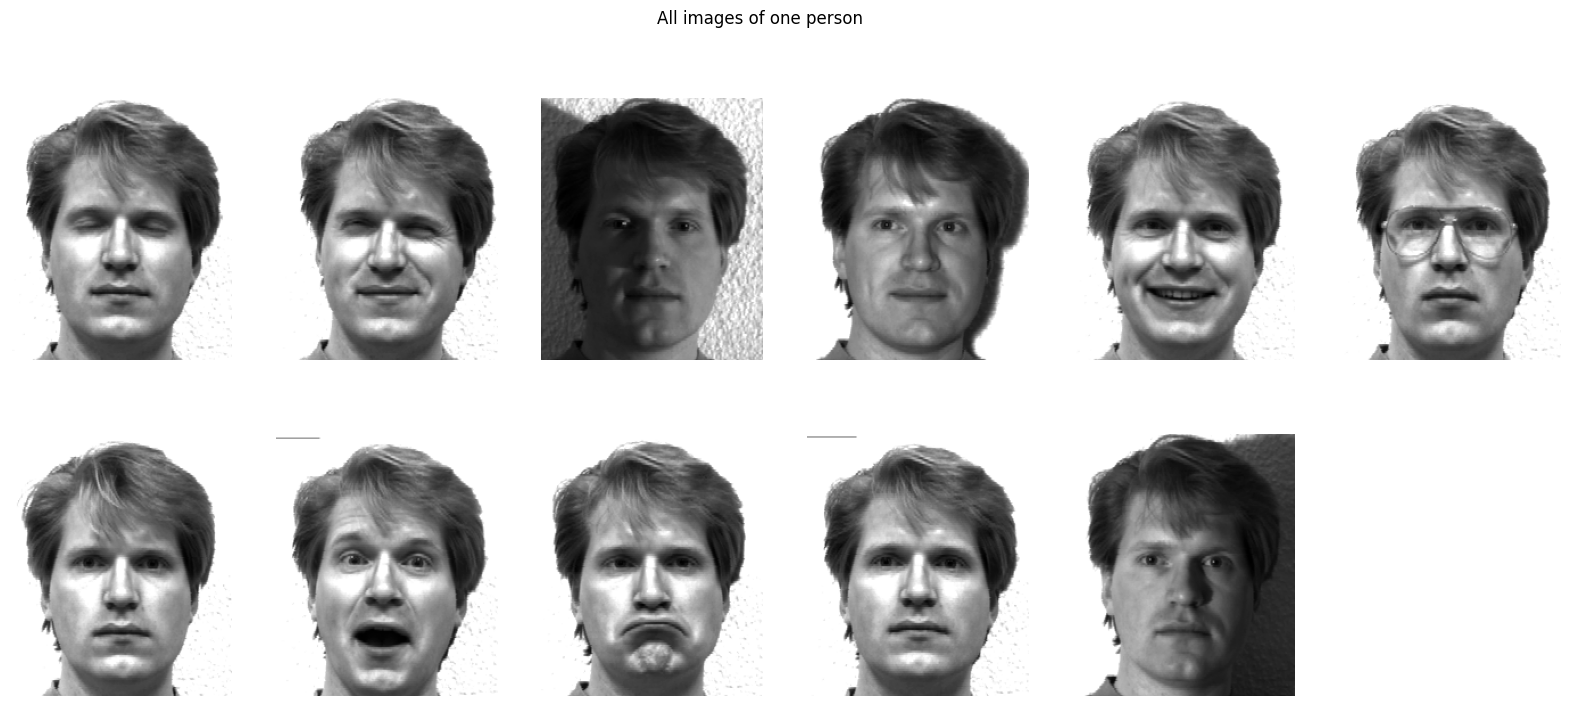

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob



def _show_images(person):
  # Khởi tạo subplot với 2 dòng 5 cột.
  fg, ax = plt.subplots(2, 6, figsize=(20, 8))
  fg.suptitle('All images of one person')
  ids = np.flatnonzero(np.array(names) == person)
  total = 0
  for i in np.arange(2):
    for j in np.arange(6):
      try:
        image = cv2.cvtColor(images[ids[total]], cv2.COLOR_BGR2RGB)
        total+=1
        ax[i, j].imshow(image)
        ax[i, j].axis('off')
      except:
        ax[i, j].axis('off')
        next

_show_images('subject01')

In [ ]:
_show_images('subject02')
_show_images('subject03')
_show_images('subject04')
_show_images('subject05')
_show_images('subject06')
_show_images('subject07')
_show_images('subject08')
_show_images('subject09')
_show_images('subject10')
_show_images('subject11')
_show_images('subject12')
_show_images('subject13')
_show_images('subject14')
_show_images('subject15')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#chia dữ liệu train và test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, names, np.array((X)), stratify = names, test_size = 1/11)
print(X_train.shape)
print(X_test.shape)
print(np.unique(y_test, return_counts=True))

(150, 224, 224)
(15, 224, 224)
(array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9'), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))


In [ ]:
import pickle

def _save_pickle(obj, link):
  with open(link, "wb") as f:
    pickle.dump(obj, f)

def _load_pickle(link):
  with open(link, "rb") as f:
    obj = pickle.load(f)
  return obj

_save_pickle(X, "YALE/X.pkl")
_save_pickle(names, "YALE/y.pkl")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None, input_tensor=Input(shape=(224, 224, 1)))
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [ ]:
gen_train = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train, axis=-1), y_train)).repeat().shuffle(1024).batch(32)
gen_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
50/50 [==============================] - 3635s 73s/step - loss: 0.7592
Epoch 2/10
50/50 [==============================] - 3585s 72s/step - loss: 0.4588
Epoch 3/10
50/50 [==============================] - 3575s 72s/step - loss: 0.3343
Epoch 4/10
50/50 [==============================] - 3589s 72s/step - loss: 0.1531
Epoch 5/10
50/50 [==============================] - 3599s 72s/step - loss: 0.0521
Epoch 6/10
50/50 [==============================] - 3551s 71s/step - loss: 0.0116
Epoch 7/10
50/50 [==============================] - 3589s 72s/step - loss: 0.0043
Epoch 8/10
50/50 [==============================] - 3693s 74s/step - loss: 5.5729e-05
Epoch 9/10
50/50 [==============================] - 3558s 71s/step - loss: 1.4769e-06
Epoch 10/10
50/50 [==============================] - 3568s 71s/step - loss: 2.1979e-06


In [ ]:
model.save('facenet_ver1.h5')

In [ ]:
X_train_vecs = model.predict(np.expand_dims(X_train, axis = -1))
X_test_vecs = model.predict(np.expand_dims(X_test, axis = -1))

1/1 [==============================] - 13s 13s/step


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

# Lấy ngẫu nhiên một bức ảnh trong test
vec = X_test_vecs[1].reshape(1, -1)
# Tìm kiếm ảnh gần nhất
_most_similarity(X_train_vecs, vec, y_train)

'subject02'

In [ ]:
# Kiểm tra độ chính xác trên Test
from sklearn.metrics import accuracy_score
y_preds = []
for vec in X_test_vecs:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vecs, vec, y_train)
  y_preds.append(y_pred)
print(accuracy_score(y_preds, y_test))

1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/facenet_ver1.h5')

In [ ]:
import pandas as pd
#đường dẫn đến thư mục chứa ảnh và file repairs.csv trong Google Drive
img_dir = "/content/drive/MyDrive/Colab Notebooks/lfw/lfw-deepfunneled/lfw-deepfunneled"
pairs_file = "/content/drive/MyDrive/Colab Notebooks/lfw/pairs.csv"

df = pd.read_csv(pairs_file, usecols=['name', 'imagenum1', 'imagenum2', 'Unnamed: 3'])
print(df.columns)

Index(['name', 'imagenum1', 'imagenum2', 'Unnamed: 3'], dtype='object')


In [ ]:
import cv2
import numpy as np

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # shape: (224, 224, 1)
    img = np.expand_dims(img, axis=0)   # shape: (1, 224, 224, 1)
    return img

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def _base_network():
    model = VGG16(include_top=True, weights=None, input_tensor=Input(shape=(224, 224, 1)))
    dense = Dense(128)(model.layers[-4].output)
    norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense)
    model = Model(inputs=[model.input], outputs=[norm2])
    return model

model = _base_network()
model.load_weights("/content/drive/MyDrive/facenet_ver1.h5")


#Đánh giá trên LFW

In [ ]:
import pandas as pd
import os

img_dir = "/content/drive/MyDrive/Colab Notebooks/lfw/lfw-deepfunneled/lfw-deepfunneled"
pairs_file = "/content/drive/MyDrive/Colab Notebooks/lfw/pairs.csv"

df = pd.read_csv(pairs_file, usecols=['name', 'imagenum1', 'imagenum2', 'Unnamed: 3'])

positive_pairs = df.iloc[:300]
negative_pairs = df.iloc[300:600]

pairs = []

# Positive pairs
for _, row in positive_pairs.iterrows():
    name = row['name']
    img1 = f"{img_dir}/{name}/{name}_{int(row['imagenum1']):04d}.jpg"
    img2 = f"{img_dir}/{name}/{name}_{int(row['imagenum2']):04d}.jpg"
    pairs.append((img1, img2, 1))

# Negative pairs
for _, row in negative_pairs.iterrows():
    name1 = row['name']
    img1 = f"{img_dir}/{name1}/{name1}_{int(row['imagenum1']):04d}.jpg"
    name2 = row['imagenum2']
    img2 = f"{img_dir}/{name2}/{name2}_{int(row['Unnamed: 3']):04d}.jpg"
    pairs.append((img1, img2, 0))


In [ ]:
#tiền xử lý
import cv2
import numpy as np

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def evaluate_model(model, pairs, threshold=0.95):
    correct = 0
    total = len(pairs)
    for img1_path, img2_path, label in tqdm(pairs, desc="Evaluating custom model"):
        try:
            img1 = preprocess_image(img1_path)
            img2 = preprocess_image(img2_path)

            vec1 = model.predict(img1)[0]
            vec2 = model.predict(img2)[0]

            sim = cosine_similarity([vec1], [vec2])[0][0]
            pred = 1 if sim >= threshold else 0

            if pred == label:
                correct += 1
        except Exception as e:
            print(f"Lỗi xử lý cặp ảnh {img1_path} và {img2_path}: {e}")
    acc = correct / total
    return acc


In [ ]:
acc = evaluate_model(model, pairs, threshold=0.95)
print(f"\n Accuracy: {acc:.4f}")

Evaluating custom model:   0%|          | 0/600 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Evaluating custom model:   0%|          | 1/600 [00:19<3:17:03, 19.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:   0%|          | 2/600 [00:24<1:49:31, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


Evaluating custom model:   0%|          | 3/600 [00:26<1:09:56,  7.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:   1%|          | 4/600 [00:28<50:19,  5.07s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Evaluating custom model:   1%|          | 5/600 [00:31<42:10,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:   1%|          | 6/600 [00:33<33:14,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


Evaluating custom model:   1%|          | 7/600 [00:35<29:19,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


Evaluating custom model:   1%|▏         | 8/600 [00:38<29:06,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:   2%|▏         | 9/600 [00:41<28:10,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:   2%|▏         | 10/600 [00:43<25:33,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:   2%|▏         | 11/600 [00:44<23:12,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:   2%|▏         | 12/600 [00:46<21:15,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:   2%|▏         | 13/600 [00:49<22:19,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:   2%|▏         | 14/600 [00:52<25:39,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


Evaluating custom model:   2%|▎         | 15/600 [00:55<24:59,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


Evaluating custom model:   3%|▎         | 16/600 [00:57<23:17,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


Evaluating custom model:   3%|▎         | 17/600 [00:59<22:52,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


Evaluating custom model:   3%|▎         | 18/600 [01:01<22:13,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:   3%|▎         | 19/600 [01:03<22:17,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:   3%|▎         | 20/600 [01:06<24:32,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


Evaluating custom model:   4%|▎         | 21/600 [01:08<22:56,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:   4%|▎         | 22/600 [01:10<20:45,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


Evaluating custom model:   4%|▍         | 23/600 [01:12<20:26,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Evaluating custom model:   4%|▍         | 24/600 [01:14<20:10,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:   4%|▍         | 25/600 [01:16<19:16,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


Evaluating custom model:   4%|▍         | 26/600 [01:19<23:23,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


Evaluating custom model:   4%|▍         | 27/600 [01:22<22:38,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


Evaluating custom model:   5%|▍         | 28/600 [01:23<19:49,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:   5%|▍         | 29/600 [01:25<18:29,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:   5%|▌         | 30/600 [01:27<18:48,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Evaluating custom model:   5%|▌         | 31/600 [01:29<19:12,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:   5%|▌         | 32/600 [01:30<18:06,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:   6%|▌         | 33/600 [01:34<21:32,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:   6%|▌         | 34/600 [01:36<20:37,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


Evaluating custom model:   6%|▌         | 35/600 [01:38<20:31,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:   6%|▌         | 36/600 [01:39<18:47,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Evaluating custom model:   6%|▌         | 37/600 [01:42<19:25,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:   6%|▋         | 38/600 [01:44<19:19,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:   6%|▋         | 39/600 [01:47<22:05,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:   7%|▋         | 40/600 [01:50<23:34,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:   7%|▋         | 41/600 [01:51<21:41,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Evaluating custom model:   7%|▋         | 42/600 [01:53<19:20,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:   7%|▋         | 43/600 [01:55<19:50,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:   7%|▋         | 44/600 [01:57<19:33,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


Evaluating custom model:   8%|▊         | 45/600 [02:00<22:25,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


Evaluating custom model:   8%|▊         | 46/600 [02:03<23:10,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


Evaluating custom model:   8%|▊         | 47/600 [02:05<21:24,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


Evaluating custom model:   8%|▊         | 48/600 [02:08<21:51,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:   8%|▊         | 49/600 [02:10<21:18,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


Evaluating custom model:   8%|▊         | 50/600 [02:11<19:30,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


Evaluating custom model:   8%|▊         | 51/600 [02:15<23:40,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:   9%|▊         | 52/600 [02:18<23:52,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


Evaluating custom model:   9%|▉         | 53/600 [02:19<21:14,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


Evaluating custom model:   9%|▉         | 54/600 [02:21<19:12,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


Evaluating custom model:   9%|▉         | 55/600 [02:23<19:28,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:   9%|▉         | 56/600 [02:25<18:59,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  10%|▉         | 57/600 [02:29<22:29,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  10%|▉         | 58/600 [02:31<21:56,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  10%|▉         | 59/600 [02:33<20:49,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  10%|█         | 60/600 [02:35<19:19,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Evaluating custom model:  10%|█         | 61/600 [02:36<17:15,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


Evaluating custom model:  10%|█         | 62/600 [02:38<17:41,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


Evaluating custom model:  10%|█         | 63/600 [02:41<19:41,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


Evaluating custom model:  11%|█         | 64/600 [02:44<22:02,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


Evaluating custom model:  11%|█         | 65/600 [02:45<19:08,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  11%|█         | 66/600 [02:48<19:32,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  11%|█         | 67/600 [02:50<19:13,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


Evaluating custom model:  11%|█▏        | 68/600 [02:52<19:03,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


Evaluating custom model:  12%|█▏        | 69/600 [02:54<17:36,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


Evaluating custom model:  12%|█▏        | 70/600 [02:56<19:31,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


Evaluating custom model:  12%|█▏        | 71/600 [02:59<21:21,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


Evaluating custom model:  12%|█▏        | 72/600 [03:01<19:32,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  12%|█▏        | 73/600 [03:03<18:00,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  12%|█▏        | 74/600 [03:05<18:17,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


Evaluating custom model:  12%|█▎        | 75/600 [03:06<17:14,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  13%|█▎        | 76/600 [03:09<19:51,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


Evaluating custom model:  13%|█▎        | 77/600 [03:12<21:11,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


Evaluating custom model:  13%|█▎        | 78/600 [03:14<19:52,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  13%|█▎        | 79/600 [03:16<18:38,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  13%|█▎        | 80/600 [03:18<18:45,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


Evaluating custom model:  14%|█▎        | 81/600 [03:20<18:59,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  14%|█▎        | 82/600 [03:24<21:42,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  14%|█▍        | 83/600 [03:26<20:40,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


Evaluating custom model:  14%|█▍        | 84/600 [03:27<18:34,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  14%|█▍        | 85/600 [03:29<16:57,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  14%|█▍        | 86/600 [03:31<16:57,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


Evaluating custom model:  14%|█▍        | 87/600 [03:34<20:20,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


Evaluating custom model:  15%|█▍        | 88/600 [03:39<26:25,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  15%|█▍        | 89/600 [03:41<23:05,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:  15%|█▌        | 90/600 [03:43<21:19,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  15%|█▌        | 91/600 [03:46<21:28,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  15%|█▌        | 92/600 [03:47<19:45,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


Evaluating custom model:  16%|█▌        | 93/600 [03:50<20:20,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  16%|█▌        | 94/600 [03:53<22:36,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


Evaluating custom model:  16%|█▌        | 95/600 [03:56<21:25,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Evaluating custom model:  16%|█▌        | 96/600 [03:58<20:14,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


Evaluating custom model:  16%|█▌        | 97/600 [04:00<19:26,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Evaluating custom model:  16%|█▋        | 98/600 [04:02<20:16,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


Evaluating custom model:  16%|█▋        | 99/600 [04:05<21:52,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


Evaluating custom model:  17%|█▋        | 100/600 [04:08<21:42,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  17%|█▋        | 101/600 [04:10<20:21,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Evaluating custom model:  17%|█▋        | 102/600 [04:12<18:42,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  17%|█▋        | 103/600 [04:15<20:19,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  17%|█▋        | 104/600 [04:19<25:41,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  18%|█▊        | 105/600 [04:24<28:32,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  18%|█▊        | 106/600 [04:27<28:15,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


Evaluating custom model:  18%|█▊        | 107/600 [04:30<27:08,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


Evaluating custom model:  18%|█▊        | 108/600 [04:33<25:11,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  18%|█▊        | 109/600 [04:36<24:43,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


Evaluating custom model:  18%|█▊        | 110/600 [04:37<20:30,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


Evaluating custom model:  18%|█▊        | 111/600 [04:39<18:53,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  19%|█▊        | 112/600 [04:41<18:14,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  19%|█▉        | 113/600 [04:43<17:22,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


Evaluating custom model:  19%|█▉        | 114/600 [04:44<16:25,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  19%|█▉        | 115/600 [04:48<19:30,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  19%|█▉        | 116/600 [04:50<19:08,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  20%|█▉        | 117/600 [04:52<18:07,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  20%|█▉        | 118/600 [04:54<17:38,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  20%|█▉        | 119/600 [04:55<15:40,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


Evaluating custom model:  20%|██        | 120/600 [04:59<18:40,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  20%|██        | 121/600 [05:02<20:40,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:  20%|██        | 122/600 [05:04<20:34,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


Evaluating custom model:  20%|██        | 123/600 [05:06<19:01,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


Evaluating custom model:  21%|██        | 124/600 [05:08<17:43,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


Evaluating custom model:  21%|██        | 125/600 [05:10<17:31,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


Evaluating custom model:  21%|██        | 126/600 [05:14<19:42,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


Evaluating custom model:  21%|██        | 127/600 [05:17<20:41,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  21%|██▏       | 128/600 [05:18<19:03,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  22%|██▏       | 129/600 [05:20<17:32,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  22%|██▏       | 130/600 [05:22<16:30,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  22%|██▏       | 131/600 [05:23<14:47,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  22%|██▏       | 132/600 [05:26<15:06,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


Evaluating custom model:  22%|██▏       | 133/600 [05:29<18:11,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


Evaluating custom model:  22%|██▏       | 134/600 [05:31<18:30,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  22%|██▎       | 135/600 [05:33<17:32,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


Evaluating custom model:  23%|██▎       | 136/600 [05:35<16:15,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Evaluating custom model:  23%|██▎       | 137/600 [05:37<15:29,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Evaluating custom model:  23%|██▎       | 138/600 [05:39<15:16,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


Evaluating custom model:  23%|██▎       | 139/600 [05:41<16:19,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


Evaluating custom model:  23%|██▎       | 140/600 [05:44<18:52,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  24%|██▎       | 141/600 [05:46<17:22,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  24%|██▎       | 142/600 [05:48<16:57,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


Evaluating custom model:  24%|██▍       | 143/600 [05:50<15:57,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Evaluating custom model:  24%|██▍       | 144/600 [05:52<15:23,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


Evaluating custom model:  24%|██▍       | 145/600 [05:54<15:35,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  24%|██▍       | 146/600 [05:57<17:34,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  24%|██▍       | 147/600 [05:59<16:07,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  25%|██▍       | 148/600 [06:01<15:24,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  25%|██▍       | 149/600 [06:03<15:17,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  25%|██▌       | 150/600 [06:04<14:55,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


Evaluating custom model:  25%|██▌       | 151/600 [06:07<15:02,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


Evaluating custom model:  25%|██▌       | 152/600 [06:10<17:34,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


Evaluating custom model:  26%|██▌       | 153/600 [06:12<17:35,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  26%|██▌       | 154/600 [06:14<16:17,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


Evaluating custom model:  26%|██▌       | 155/600 [06:17<17:28,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


Evaluating custom model:  26%|██▌       | 156/600 [06:18<15:53,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  26%|██▌       | 157/600 [06:20<15:07,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  26%|██▋       | 158/600 [06:23<17:39,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  26%|██▋       | 159/600 [06:26<17:24,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  27%|██▋       | 160/600 [06:27<15:39,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  27%|██▋       | 161/600 [06:29<13:50,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  27%|██▋       | 162/600 [06:30<13:55,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  27%|██▋       | 163/600 [06:32<13:59,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  27%|██▋       | 164/600 [06:34<13:55,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  28%|██▊       | 165/600 [06:38<16:47,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  28%|██▊       | 166/600 [06:39<15:40,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  28%|██▊       | 167/600 [06:41<14:31,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  28%|██▊       | 168/600 [06:43<14:19,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  28%|██▊       | 169/600 [06:46<16:05,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Evaluating custom model:  28%|██▊       | 170/600 [06:48<15:34,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


Evaluating custom model:  28%|██▊       | 171/600 [06:51<17:04,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


Evaluating custom model:  29%|██▊       | 172/600 [06:53<17:07,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  29%|██▉       | 173/600 [06:55<15:56,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:  29%|██▉       | 174/600 [06:57<15:27,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


Evaluating custom model:  29%|██▉       | 175/600 [06:59<14:44,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Evaluating custom model:  29%|██▉       | 176/600 [07:01<14:19,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  30%|██▉       | 177/600 [07:03<15:41,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


Evaluating custom model:  30%|██▉       | 178/600 [07:07<17:50,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  30%|██▉       | 179/600 [07:09<16:54,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  30%|███       | 180/600 [07:11<15:29,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  30%|███       | 181/600 [07:12<14:44,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  30%|███       | 182/600 [07:14<14:20,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


Evaluating custom model:  30%|███       | 183/600 [07:17<15:02,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


Evaluating custom model:  31%|███       | 184/600 [07:20<17:02,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


Evaluating custom model:  31%|███       | 185/600 [07:23<17:10,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  31%|███       | 186/600 [07:24<15:55,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  31%|███       | 187/600 [07:26<15:16,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  31%|███▏      | 188/600 [07:28<14:12,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


Evaluating custom model:  32%|███▏      | 189/600 [07:31<15:00,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


Evaluating custom model:  32%|███▏      | 190/600 [07:33<15:55,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  32%|███▏      | 191/600 [07:35<14:48,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  32%|███▏      | 192/600 [07:37<14:00,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  32%|███▏      | 193/600 [07:39<13:34,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Evaluating custom model:  32%|███▏      | 194/600 [07:41<13:13,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  32%|███▎      | 195/600 [07:42<12:37,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  33%|███▎      | 196/600 [07:45<13:58,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


Evaluating custom model:  33%|███▎      | 197/600 [07:47<15:09,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  33%|███▎      | 198/600 [07:49<14:28,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  33%|███▎      | 199/600 [07:51<13:58,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


Evaluating custom model:  33%|███▎      | 200/600 [07:53<13:30,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Evaluating custom model:  34%|███▎      | 201/600 [07:55<13:31,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


Evaluating custom model:  34%|███▎      | 202/600 [07:58<14:35,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


Evaluating custom model:  34%|███▍      | 203/600 [08:01<16:07,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


Evaluating custom model:  34%|███▍      | 204/600 [08:03<14:52,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  34%|███▍      | 205/600 [08:04<13:25,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Evaluating custom model:  34%|███▍      | 206/600 [08:06<12:59,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  34%|███▍      | 207/600 [08:08<12:48,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  35%|███▍      | 208/600 [08:10<12:24,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


Evaluating custom model:  35%|███▍      | 209/600 [08:13<14:42,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  35%|███▌      | 210/600 [08:15<14:13,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  35%|███▌      | 211/600 [08:17<13:54,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  35%|███▌      | 212/600 [08:19<13:16,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


Evaluating custom model:  36%|███▌      | 213/600 [08:21<13:07,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Evaluating custom model:  36%|███▌      | 214/600 [08:23<12:50,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


Evaluating custom model:  36%|███▌      | 215/600 [08:25<12:53,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  36%|███▌      | 216/600 [08:28<14:39,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


Evaluating custom model:  36%|███▌      | 217/600 [08:30<14:42,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


Evaluating custom model:  36%|███▋      | 218/600 [08:32<13:35,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  36%|███▋      | 219/600 [08:33<12:52,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  37%|███▋      | 220/600 [08:35<12:32,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


Evaluating custom model:  37%|███▋      | 221/600 [08:37<12:42,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  37%|███▋      | 222/600 [08:41<15:15,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


Evaluating custom model:  37%|███▋      | 223/600 [08:43<14:57,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  37%|███▋      | 224/600 [08:45<13:34,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


Evaluating custom model:  38%|███▊      | 225/600 [08:47<12:59,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  38%|███▊      | 226/600 [08:48<12:24,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Evaluating custom model:  38%|███▊      | 227/600 [08:50<12:04,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


Evaluating custom model:  38%|███▊      | 228/600 [08:52<12:23,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  38%|███▊      | 229/600 [08:55<14:20,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


Evaluating custom model:  38%|███▊      | 230/600 [08:57<13:26,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


Evaluating custom model:  38%|███▊      | 231/600 [08:59<12:24,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


Evaluating custom model:  39%|███▊      | 232/600 [09:01<11:34,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


Evaluating custom model:  39%|███▉      | 233/600 [09:02<11:12,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  39%|███▉      | 234/600 [09:04<11:26,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


Evaluating custom model:  39%|███▉      | 235/600 [09:07<12:43,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


Evaluating custom model:  39%|███▉      | 236/600 [09:10<14:24,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  40%|███▉      | 237/600 [09:12<13:13,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  40%|███▉      | 238/600 [09:13<12:35,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


Evaluating custom model:  40%|███▉      | 239/600 [09:15<12:09,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


Evaluating custom model:  40%|████      | 240/600 [09:17<12:00,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


Evaluating custom model:  40%|████      | 241/600 [09:19<11:28,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


Evaluating custom model:  40%|████      | 242/600 [09:22<13:27,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


Evaluating custom model:  40%|████      | 243/600 [09:25<14:20,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


Evaluating custom model:  41%|████      | 244/600 [09:27<13:39,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  41%|████      | 245/600 [09:30<15:27,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  41%|████      | 246/600 [09:33<14:56,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


Evaluating custom model:  41%|████      | 247/600 [09:34<12:48,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


Evaluating custom model:  41%|████▏     | 248/600 [09:37<14:44,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  42%|████▏     | 249/600 [09:39<13:43,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


Evaluating custom model:  42%|████▏     | 250/600 [09:41<12:44,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  42%|████▏     | 251/600 [09:43<12:47,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  42%|████▏     | 252/600 [09:45<11:47,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  42%|████▏     | 253/600 [09:47<11:29,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


Evaluating custom model:  42%|████▏     | 254/600 [09:50<13:15,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


Evaluating custom model:  42%|████▎     | 255/600 [09:52<12:54,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  43%|████▎     | 256/600 [09:53<11:50,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  43%|████▎     | 257/600 [09:56<11:51,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Evaluating custom model:  43%|████▎     | 258/600 [09:57<11:23,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  43%|████▎     | 259/600 [09:59<11:05,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


Evaluating custom model:  43%|████▎     | 260/600 [10:01<10:55,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  44%|████▎     | 261/600 [10:04<13:12,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  44%|████▎     | 262/600 [10:06<12:16,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  44%|████▍     | 263/600 [10:08<11:46,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  44%|████▍     | 264/600 [10:10<11:13,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


Evaluating custom model:  44%|████▍     | 265/600 [10:12<10:31,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  44%|████▍     | 266/600 [10:13<10:02,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


Evaluating custom model:  44%|████▍     | 267/600 [10:15<10:52,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


Evaluating custom model:  45%|████▍     | 268/600 [10:18<12:00,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


Evaluating custom model:  45%|████▍     | 269/600 [10:20<11:25,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  45%|████▌     | 270/600 [10:22<11:01,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  45%|████▌     | 271/600 [10:23<10:25,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


Evaluating custom model:  45%|████▌     | 272/600 [10:25<10:13,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:  46%|████▌     | 273/600 [10:27<10:12,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  46%|████▌     | 274/600 [10:30<11:21,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


Evaluating custom model:  46%|████▌     | 275/600 [10:33<12:51,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  46%|████▌     | 276/600 [10:35<12:09,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  46%|████▌     | 277/600 [10:37<11:41,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


Evaluating custom model:  46%|████▋     | 278/600 [10:39<11:23,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  46%|████▋     | 279/600 [10:41<11:00,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


Evaluating custom model:  47%|████▋     | 280/600 [10:43<11:21,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


Evaluating custom model:  47%|████▋     | 281/600 [10:46<12:43,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  47%|████▋     | 282/600 [10:48<11:36,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  47%|████▋     | 283/600 [10:49<10:49,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


Evaluating custom model:  47%|████▋     | 284/600 [10:51<10:25,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  48%|████▊     | 285/600 [10:53<10:24,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


Evaluating custom model:  48%|████▊     | 286/600 [10:57<12:59,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


Evaluating custom model:  48%|████▊     | 287/600 [11:00<13:42,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  48%|████▊     | 288/600 [11:02<12:34,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


Evaluating custom model:  48%|████▊     | 289/600 [11:04<12:56,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


Evaluating custom model:  48%|████▊     | 290/600 [11:06<12:11,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


Evaluating custom model:  48%|████▊     | 291/600 [11:09<13:07,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


Evaluating custom model:  49%|████▊     | 292/600 [11:12<13:37,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


Evaluating custom model:  49%|████▉     | 293/600 [11:15<13:28,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  49%|████▉     | 294/600 [11:17<11:51,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  49%|████▉     | 295/600 [11:18<10:42,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  49%|████▉     | 296/600 [11:20<10:27,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  50%|████▉     | 297/600 [11:22<10:21,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


Evaluating custom model:  50%|████▉     | 298/600 [11:24<10:22,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  50%|████▉     | 299/600 [11:28<12:32,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  50%|█████     | 300/600 [11:29<11:15,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  50%|█████     | 301/600 [11:31<10:27,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


Evaluating custom model:  50%|█████     | 302/600 [11:33<09:40,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


Evaluating custom model:  50%|█████     | 303/600 [11:34<08:40,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  51%|█████     | 304/600 [11:36<08:55,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


Evaluating custom model:  51%|█████     | 305/600 [11:38<08:29,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  51%|█████     | 306/600 [11:41<10:27,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


Evaluating custom model:  51%|█████     | 307/600 [11:42<10:04,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  51%|█████▏    | 308/600 [11:44<09:45,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  52%|█████▏    | 309/600 [11:46<09:09,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


Evaluating custom model:  52%|█████▏    | 310/600 [11:48<08:59,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  52%|█████▏    | 311/600 [11:49<08:33,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


Evaluating custom model:  52%|█████▏    | 312/600 [11:51<08:38,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


Evaluating custom model:  52%|█████▏    | 313/600 [11:55<10:54,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  52%|█████▏    | 314/600 [11:56<09:39,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  52%|█████▎    | 315/600 [11:58<09:17,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  53%|█████▎    | 316/600 [12:00<08:53,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  53%|█████▎    | 317/600 [12:01<07:59,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  53%|█████▎    | 318/600 [12:03<08:13,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


Evaluating custom model:  53%|█████▎    | 319/600 [12:04<07:35,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


Evaluating custom model:  53%|█████▎    | 320/600 [12:07<09:26,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  54%|█████▎    | 321/600 [12:09<09:47,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


Evaluating custom model:  54%|█████▎    | 322/600 [12:11<09:05,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:  54%|█████▍    | 323/600 [12:13<08:40,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  54%|█████▍    | 324/600 [12:15<08:42,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  54%|█████▍    | 325/600 [12:16<08:12,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  54%|█████▍    | 326/600 [12:18<08:07,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


Evaluating custom model:  55%|█████▍    | 327/600 [12:20<08:29,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


Evaluating custom model:  55%|█████▍    | 328/600 [12:23<09:33,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


Evaluating custom model:  55%|█████▍    | 329/600 [12:24<09:16,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  55%|█████▌    | 330/600 [12:26<09:06,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Evaluating custom model:  55%|█████▌    | 331/600 [12:28<08:51,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Evaluating custom model:  55%|█████▌    | 332/600 [12:30<08:42,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


Evaluating custom model:  56%|█████▌    | 333/600 [12:32<07:52,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  56%|█████▌    | 334/600 [12:34<08:46,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  56%|█████▌    | 335/600 [12:37<09:42,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  56%|█████▌    | 336/600 [12:39<09:22,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  56%|█████▌    | 337/600 [12:41<09:09,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  56%|█████▋    | 338/600 [12:42<08:33,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  56%|█████▋    | 339/600 [12:44<08:18,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  57%|█████▋    | 340/600 [12:46<07:53,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


Evaluating custom model:  57%|█████▋    | 341/600 [12:48<09:02,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  57%|█████▋    | 342/600 [12:51<09:31,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  57%|█████▋    | 343/600 [12:52<08:32,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  57%|█████▋    | 344/600 [12:54<07:38,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  57%|█████▊    | 345/600 [12:56<07:41,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  58%|█████▊    | 346/600 [12:57<07:35,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  58%|█████▊    | 347/600 [12:59<07:24,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


Evaluating custom model:  58%|█████▊    | 348/600 [13:02<09:28,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Evaluating custom model:  58%|█████▊    | 349/600 [13:04<08:54,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  58%|█████▊    | 350/600 [13:06<08:14,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  58%|█████▊    | 351/600 [13:08<08:05,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  59%|█████▊    | 352/600 [13:09<07:18,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  59%|█████▉    | 353/600 [13:10<06:44,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  59%|█████▉    | 354/600 [13:13<07:14,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


Evaluating custom model:  59%|█████▉    | 355/600 [13:15<07:34,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


Evaluating custom model:  59%|█████▉    | 356/600 [13:17<08:46,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  60%|█████▉    | 357/600 [13:19<08:13,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


Evaluating custom model:  60%|█████▉    | 358/600 [13:21<08:17,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  60%|█████▉    | 359/600 [13:23<07:44,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Evaluating custom model:  60%|██████    | 360/600 [13:25<07:21,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  60%|██████    | 361/600 [13:26<06:41,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


Evaluating custom model:  60%|██████    | 362/600 [13:28<07:31,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


Evaluating custom model:  60%|██████    | 363/600 [13:31<08:30,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  61%|██████    | 364/600 [13:33<08:05,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  61%|██████    | 365/600 [13:34<07:25,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  61%|██████    | 366/600 [13:36<07:11,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


Evaluating custom model:  61%|██████    | 367/600 [13:37<06:35,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  61%|██████▏   | 368/600 [13:39<06:30,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  62%|██████▏   | 369/600 [13:40<06:02,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


Evaluating custom model:  62%|██████▏   | 370/600 [13:43<07:40,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:  62%|██████▏   | 371/600 [13:46<08:00,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  62%|██████▏   | 372/600 [13:47<07:29,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


Evaluating custom model:  62%|██████▏   | 373/600 [13:49<07:26,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Evaluating custom model:  62%|██████▏   | 374/600 [13:51<06:45,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  62%|██████▎   | 375/600 [13:52<06:27,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Evaluating custom model:  63%|██████▎   | 376/600 [13:54<06:00,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  63%|██████▎   | 377/600 [13:57<07:42,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  63%|██████▎   | 378/600 [13:59<07:57,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Evaluating custom model:  63%|██████▎   | 379/600 [14:03<09:18,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  63%|██████▎   | 380/600 [14:04<08:16,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  64%|██████▎   | 381/600 [14:06<08:01,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Evaluating custom model:  64%|██████▎   | 382/600 [14:08<07:28,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


Evaluating custom model:  64%|██████▍   | 383/600 [14:11<08:23,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  64%|██████▍   | 384/600 [14:13<08:05,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  64%|██████▍   | 385/600 [14:15<07:35,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  64%|██████▍   | 386/600 [14:17<07:23,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Evaluating custom model:  64%|██████▍   | 387/600 [14:19<07:08,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


Evaluating custom model:  65%|██████▍   | 388/600 [14:20<06:22,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Evaluating custom model:  65%|██████▍   | 389/600 [14:22<06:30,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  65%|██████▌   | 390/600 [14:24<06:49,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


Evaluating custom model:  65%|██████▌   | 391/600 [14:27<07:21,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  65%|██████▌   | 392/600 [14:28<06:45,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  66%|██████▌   | 393/600 [14:30<06:15,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  66%|██████▌   | 394/600 [14:31<06:03,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  66%|██████▌   | 395/600 [14:33<06:02,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  66%|██████▌   | 396/600 [14:35<06:17,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  66%|██████▌   | 397/600 [14:37<06:45,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


Evaluating custom model:  66%|██████▋   | 398/600 [14:41<07:52,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  66%|██████▋   | 399/600 [14:42<07:12,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


Evaluating custom model:  67%|██████▋   | 400/600 [14:45<07:15,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  67%|██████▋   | 401/600 [14:47<06:59,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  67%|██████▋   | 402/600 [14:48<06:38,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


Evaluating custom model:  67%|██████▋   | 403/600 [14:51<06:46,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


Evaluating custom model:  67%|██████▋   | 404/600 [14:53<07:34,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


Evaluating custom model:  68%|██████▊   | 405/600 [14:55<06:52,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  68%|██████▊   | 406/600 [14:57<06:18,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  68%|██████▊   | 407/600 [14:59<06:23,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


Evaluating custom model:  68%|██████▊   | 408/600 [15:00<05:58,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  68%|██████▊   | 409/600 [15:02<05:45,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


Evaluating custom model:  68%|██████▊   | 410/600 [15:04<06:14,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


Evaluating custom model:  68%|██████▊   | 411/600 [15:07<06:56,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  69%|██████▊   | 412/600 [15:09<06:23,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  69%|██████▉   | 413/600 [15:10<05:58,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  69%|██████▉   | 414/600 [15:12<06:04,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


Evaluating custom model:  69%|██████▉   | 415/600 [15:14<05:48,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:  69%|██████▉   | 416/600 [15:15<05:17,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


Evaluating custom model:  70%|██████▉   | 417/600 [15:17<05:07,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  70%|██████▉   | 418/600 [15:20<06:05,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Evaluating custom model:  70%|██████▉   | 419/600 [15:22<05:59,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  70%|███████   | 420/600 [15:24<05:48,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


Evaluating custom model:  70%|███████   | 421/600 [15:25<05:46,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


Evaluating custom model:  70%|███████   | 422/600 [15:27<05:41,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


Evaluating custom model:  70%|███████   | 423/600 [15:29<05:35,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


Evaluating custom model:  71%|███████   | 424/600 [15:31<05:36,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  71%|███████   | 425/600 [15:34<06:30,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  71%|███████   | 426/600 [15:36<06:31,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Evaluating custom model:  71%|███████   | 427/600 [15:38<05:40,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  71%|███████▏  | 428/600 [15:39<05:27,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  72%|███████▏  | 429/600 [15:41<04:59,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  72%|███████▏  | 430/600 [15:42<04:35,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  72%|███████▏  | 431/600 [15:44<04:54,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


Evaluating custom model:  72%|███████▏  | 432/600 [15:47<05:42,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  72%|███████▏  | 433/600 [15:49<05:42,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  72%|███████▏  | 434/600 [15:51<05:22,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


Evaluating custom model:  72%|███████▎  | 435/600 [15:53<05:26,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  73%|███████▎  | 436/600 [15:54<05:09,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Evaluating custom model:  73%|███████▎  | 437/600 [15:56<04:52,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  73%|███████▎  | 438/600 [15:58<04:46,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


Evaluating custom model:  73%|███████▎  | 439/600 [16:00<05:30,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


Evaluating custom model:  73%|███████▎  | 440/600 [16:03<05:39,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  74%|███████▎  | 441/600 [16:04<04:58,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  74%|███████▎  | 442/600 [16:06<04:44,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Evaluating custom model:  74%|███████▍  | 443/600 [16:07<04:32,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  74%|███████▍  | 444/600 [16:09<04:29,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  74%|███████▍  | 445/600 [16:11<04:19,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


Evaluating custom model:  74%|███████▍  | 446/600 [16:13<04:57,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


Evaluating custom model:  74%|███████▍  | 447/600 [16:16<06:03,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  75%|███████▍  | 448/600 [16:18<05:14,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


Evaluating custom model:  75%|███████▍  | 449/600 [16:19<04:51,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  75%|███████▌  | 450/600 [16:21<04:35,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Evaluating custom model:  75%|███████▌  | 451/600 [16:23<04:35,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


Evaluating custom model:  75%|███████▌  | 452/600 [16:25<04:41,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  76%|███████▌  | 453/600 [16:27<04:56,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


Evaluating custom model:  76%|███████▌  | 454/600 [16:31<05:50,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


Evaluating custom model:  76%|███████▌  | 455/600 [16:32<05:19,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  76%|███████▌  | 456/600 [16:34<04:56,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:  76%|███████▌  | 457/600 [16:35<04:29,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


Evaluating custom model:  76%|███████▋  | 458/600 [16:38<04:35,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


Evaluating custom model:  76%|███████▋  | 459/600 [16:39<04:31,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


Evaluating custom model:  77%|███████▋  | 460/600 [16:42<05:02,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  77%|███████▋  | 461/600 [16:44<04:58,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


Evaluating custom model:  77%|███████▋  | 462/600 [16:46<04:22,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


Evaluating custom model:  77%|███████▋  | 463/600 [16:47<04:01,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


Evaluating custom model:  77%|███████▋  | 464/600 [16:49<03:58,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Evaluating custom model:  78%|███████▊  | 465/600 [16:50<03:45,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  78%|███████▊  | 466/600 [16:52<03:42,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


Evaluating custom model:  78%|███████▊  | 467/600 [16:54<04:13,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


Evaluating custom model:  78%|███████▊  | 468/600 [16:57<04:56,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:  78%|███████▊  | 469/600 [17:00<04:49,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  78%|███████▊  | 470/600 [17:01<04:15,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  78%|███████▊  | 471/600 [17:02<03:59,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


Evaluating custom model:  79%|███████▊  | 472/600 [17:04<03:41,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Evaluating custom model:  79%|███████▉  | 473/600 [17:05<03:26,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


Evaluating custom model:  79%|███████▉  | 474/600 [17:08<04:03,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


Evaluating custom model:  79%|███████▉  | 475/600 [17:11<04:32,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  79%|███████▉  | 476/600 [17:12<04:11,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  80%|███████▉  | 477/600 [17:14<03:44,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  80%|███████▉  | 478/600 [17:15<03:27,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


Evaluating custom model:  80%|███████▉  | 479/600 [17:17<03:39,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


Evaluating custom model:  80%|████████  | 480/600 [17:19<03:21,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Evaluating custom model:  80%|████████  | 481/600 [17:20<03:16,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


Evaluating custom model:  80%|████████  | 482/600 [17:23<03:59,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


Evaluating custom model:  80%|████████  | 483/600 [17:25<03:57,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  81%|████████  | 484/600 [17:27<03:39,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


Evaluating custom model:  81%|████████  | 485/600 [17:28<03:28,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  81%|████████  | 486/600 [17:30<03:25,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Evaluating custom model:  81%|████████  | 487/600 [17:31<03:06,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


Evaluating custom model:  81%|████████▏ | 488/600 [17:33<02:55,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  82%|████████▏ | 489/600 [17:34<02:48,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


Evaluating custom model:  82%|████████▏ | 490/600 [17:37<03:26,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


Evaluating custom model:  82%|████████▏ | 491/600 [17:39<03:28,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  82%|████████▏ | 492/600 [17:41<03:22,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  82%|████████▏ | 493/600 [17:42<03:02,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  82%|████████▏ | 494/600 [17:44<02:55,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  82%|████████▎ | 495/600 [17:45<02:52,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  83%|████████▎ | 496/600 [17:47<02:46,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  83%|████████▎ | 497/600 [17:48<02:46,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


Evaluating custom model:  83%|████████▎ | 498/600 [17:51<03:19,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Evaluating custom model:  83%|████████▎ | 499/600 [17:53<03:20,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  83%|████████▎ | 500/600 [17:55<03:05,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  84%|████████▎ | 501/600 [17:57<03:07,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  84%|████████▎ | 502/600 [17:59<03:07,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  84%|████████▍ | 503/600 [18:00<02:54,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  84%|████████▍ | 504/600 [18:02<02:58,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


Evaluating custom model:  84%|████████▍ | 505/600 [18:05<03:20,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  84%|████████▍ | 506/600 [18:07<03:25,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


Evaluating custom model:  84%|████████▍ | 507/600 [18:09<03:00,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  85%|████████▍ | 508/600 [18:10<02:42,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  85%|████████▍ | 509/600 [18:12<02:45,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


Evaluating custom model:  85%|████████▌ | 510/600 [18:13<02:30,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


Evaluating custom model:  85%|████████▌ | 511/600 [18:15<02:27,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


Evaluating custom model:  85%|████████▌ | 512/600 [18:17<02:50,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


Evaluating custom model:  86%|████████▌ | 513/600 [18:20<03:16,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Evaluating custom model:  86%|████████▌ | 514/600 [18:22<02:57,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  86%|████████▌ | 515/600 [18:24<02:45,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


Evaluating custom model:  86%|████████▌ | 516/600 [18:25<02:37,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  86%|████████▌ | 517/600 [18:27<02:32,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Evaluating custom model:  86%|████████▋ | 518/600 [18:28<02:18,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


Evaluating custom model:  86%|████████▋ | 519/600 [18:31<02:37,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


Evaluating custom model:  87%|████████▋ | 520/600 [18:34<02:58,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  87%|████████▋ | 521/600 [18:36<02:43,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  87%|████████▋ | 522/600 [18:38<02:37,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  87%|████████▋ | 523/600 [18:39<02:24,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  87%|████████▋ | 524/600 [18:41<02:20,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Evaluating custom model:  88%|████████▊ | 525/600 [18:43<02:23,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  88%|████████▊ | 526/600 [18:45<02:28,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


Evaluating custom model:  88%|████████▊ | 527/600 [18:48<02:54,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  88%|████████▊ | 528/600 [18:50<02:33,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  88%|████████▊ | 529/600 [18:51<02:14,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Evaluating custom model:  88%|████████▊ | 530/600 [18:53<02:11,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


Evaluating custom model:  88%|████████▊ | 531/600 [18:54<01:58,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


Evaluating custom model:  89%|████████▊ | 532/600 [18:56<01:50,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


Evaluating custom model:  89%|████████▉ | 533/600 [18:57<01:48,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


Evaluating custom model:  89%|████████▉ | 534/600 [19:00<02:09,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


Evaluating custom model:  89%|████████▉ | 535/600 [19:02<02:09,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  89%|████████▉ | 536/600 [19:04<01:56,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  90%|████████▉ | 537/600 [19:05<01:46,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  90%|████████▉ | 538/600 [19:06<01:38,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


Evaluating custom model:  90%|████████▉ | 539/600 [19:08<01:37,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  90%|█████████ | 540/600 [19:10<01:35,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  90%|█████████ | 541/600 [19:11<01:29,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  90%|█████████ | 542/600 [19:14<01:55,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  90%|█████████ | 543/600 [19:16<01:53,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


Evaluating custom model:  91%|█████████ | 544/600 [19:18<01:46,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  91%|█████████ | 545/600 [19:20<01:51,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  91%|█████████ | 546/600 [19:21<01:38,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


Evaluating custom model:  91%|█████████ | 547/600 [19:23<01:32,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  91%|█████████▏| 548/600 [19:25<01:28,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


Evaluating custom model:  92%|█████████▏| 549/600 [19:27<01:42,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  92%|█████████▏| 550/600 [19:29<01:40,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


Evaluating custom model:  92%|█████████▏| 551/600 [19:31<01:31,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  92%|█████████▏| 552/600 [19:33<01:27,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  92%|█████████▏| 553/600 [19:34<01:24,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  92%|█████████▏| 554/600 [19:36<01:22,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


Evaluating custom model:  92%|█████████▎| 555/600 [19:38<01:18,  1.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


Evaluating custom model:  93%|█████████▎| 556/600 [19:40<01:28,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


Evaluating custom model:  93%|█████████▎| 557/600 [19:43<01:32,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


Evaluating custom model:  93%|█████████▎| 558/600 [19:45<01:24,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


Evaluating custom model:  93%|█████████▎| 559/600 [19:46<01:19,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


Evaluating custom model:  93%|█████████▎| 560/600 [19:48<01:09,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


Evaluating custom model:  94%|█████████▎| 561/600 [19:49<01:03,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


Evaluating custom model:  94%|█████████▎| 562/600 [19:51<01:01,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


Evaluating custom model:  94%|█████████▍| 563/600 [19:52<00:58,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


Evaluating custom model:  94%|█████████▍| 564/600 [19:54<00:59,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  94%|█████████▍| 565/600 [19:57<01:09,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Evaluating custom model:  94%|█████████▍| 566/600 [19:58<01:02,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  94%|█████████▍| 567/600 [20:00<01:01,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  95%|█████████▍| 568/600 [20:02<00:57,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


Evaluating custom model:  95%|█████████▍| 569/600 [20:03<00:55,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


Evaluating custom model:  95%|█████████▌| 570/600 [20:05<00:49,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Evaluating custom model:  95%|█████████▌| 571/600 [20:06<00:48,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


Evaluating custom model:  95%|█████████▌| 572/600 [20:09<00:57,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Evaluating custom model:  96%|█████████▌| 573/600 [20:12<00:55,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


Evaluating custom model:  96%|█████████▌| 574/600 [20:13<00:49,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


Evaluating custom model:  96%|█████████▌| 575/600 [20:15<00:47,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


Evaluating custom model:  96%|█████████▌| 576/600 [20:17<00:43,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  96%|█████████▌| 577/600 [20:18<00:41,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


Evaluating custom model:  96%|█████████▋| 578/600 [20:20<00:39,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


Evaluating custom model:  96%|█████████▋| 579/600 [20:23<00:45,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


Evaluating custom model:  97%|█████████▋| 580/600 [20:26<00:45,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


Evaluating custom model:  97%|█████████▋| 581/600 [20:27<00:39,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


Evaluating custom model:  97%|█████████▋| 582/600 [20:29<00:36,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


Evaluating custom model:  97%|█████████▋| 583/600 [20:31<00:32,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


Evaluating custom model:  97%|█████████▋| 584/600 [20:32<00:28,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


Evaluating custom model:  98%|█████████▊| 585/600 [20:34<00:25,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


Evaluating custom model:  98%|█████████▊| 586/600 [20:37<00:29,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


Evaluating custom model:  98%|█████████▊| 587/600 [20:39<00:27,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


Evaluating custom model:  98%|█████████▊| 588/600 [20:41<00:22,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


Evaluating custom model:  98%|█████████▊| 589/600 [20:42<00:20,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


Evaluating custom model:  98%|█████████▊| 590/600 [20:44<00:17,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


Evaluating custom model:  98%|█████████▊| 591/600 [20:45<00:15,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


Evaluating custom model:  99%|█████████▊| 592/600 [20:47<00:12,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


Evaluating custom model:  99%|█████████▉| 593/600 [20:49<00:11,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Evaluating custom model:  99%|█████████▉| 594/600 [20:51<00:12,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


Evaluating custom model:  99%|█████████▉| 595/600 [20:53<00:10,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


Evaluating custom model:  99%|█████████▉| 596/600 [20:55<00:07,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


Evaluating custom model: 100%|█████████▉| 597/600 [20:57<00:05,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


Evaluating custom model: 100%|█████████▉| 598/600 [20:58<00:03,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


Evaluating custom model: 100%|█████████▉| 599/600 [21:00<00:01,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


Evaluating custom model: 100%|██████████| 600/600 [21:01<00:00,  2.10s/it]


 Accuracy: 0.5617
